## DF

In [499]:
import pandas as pd
from pathlib import Path

BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
PLOTS_PATH = BASE_PATH / "notebooks" / "plots"

df = pd.read_csv(DATA_PATH / "raw" / "train.csv")

print(f"df.shape: {df.shape}")
print(f"df.dtypes:  \n{df.dtypes}")
df.head()


df.shape: (891, 12)
df.dtypes:  
PassengerId      int64
Survived         int64
Pclass           int64
Name               str
Sex                str
Age            float64
SibSp            int64
Parch            int64
Ticket             str
Fare           float64
Cabin              str
Embarked           str
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Find NaN and duplicated**

In [500]:
missing_values = df.isna().sum().sort_values(ascending=False)

print(f"Missing values:\n{missing_values}", end="\n\n")
print(f"Duplicated values:\n{df.duplicated().sum()}")

Missing values:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

Duplicated values:
0


**Drop unnecessary columns**

In [501]:
cols_to_drop = ["Ticket", "Cabin"]

df = df.copy().drop(columns=cols_to_drop)
print(f"Duplicated values:\n{df.duplicated().sum()}")
df.head()

Duplicated values:
0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


**outliers**

In [502]:
num_cols = ["Age", "Fare"]
for col in num_cols:
    print(f"\n{col}")
    print(df.groupby("Sex")[col].agg(["min", "max", "mean", "std", "count"]))


Age
         min   max       mean        std  count
Sex                                            
female  0.75  63.0  27.915709  14.110146    261
male    0.42  80.0  30.726645  14.678201    453

Fare
         min       max       mean        std  count
Sex                                                
female  6.75  512.3292  44.479818  57.997698    314
male    0.00  512.3292  25.523893  43.138263    577


**Survival rate `["Sex", "Pclass", "Embarked"]`**

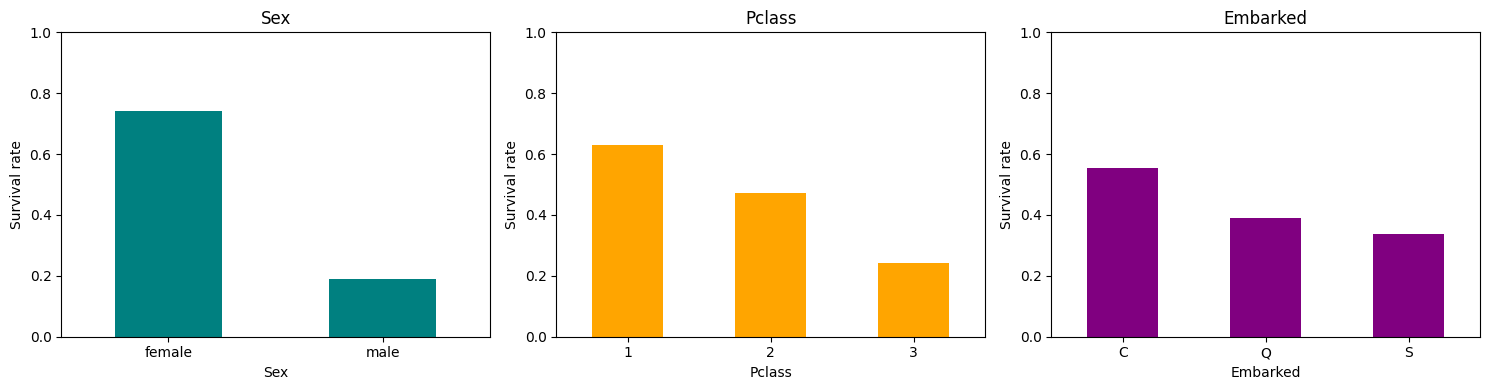

In [503]:
import matplotlib.pyplot as plt


def plot_survival_rates(df, columns, orders=None, colors=None):
    n = len(columns)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))

    if n == 1:
        axes = [axes]

    for i, (ax, col) in enumerate(zip(axes, columns)):
        rates = df.groupby(col)["Survived"].mean()

        if orders and col in orders:
            rates = rates.reindex(orders[col])

        color = colors[i] if colors else None
        rates.plot(kind="bar", ax=ax, color=color)

        ax.set_title(col)
        ax.set_ylim(0, 1)
        ax.set_ylabel("Survival rate")
        ax.tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.show()


plot_survival_rates(
    df,
    ["Sex", "Pclass", "Embarked"],
    orders={"Pclass": [1, 2, 3], "Embarked": ["C", "Q", "S"]},
    colors=["teal", "orange", "purple"],
)

In [504]:
import pandas as pd

def build_categorical_summary(df, cols):
    tables = []

    for col in cols:
        group = df.groupby(col)["Survived"].agg(["count", "mean"])
        group = group.rename(columns={"count": "Count", "mean": "Rate"})

        group["SurvivalRate"] = ((group["Count"] / len(df)) * 100).round().astype(int).map(lambda x: f"{x}%")   
        group["Feature"] = col

        tables.append(group.reset_index().rename(columns={col: "Value"}))

    summary = pd.concat(tables, ignore_index=True)
    summary = summary[["Feature", "Value", "Count", "SurvivalRate"]]

    return summary

summary = build_categorical_summary(df, ["Sex", "Pclass", "Embarked"])
summary

,Feature,Value,Count,SurvivalRate
0,Sex,female,314,35%
1,Sex,male,577,65%
2,Pclass,1,216,24%
3,Pclass,2,184,21%
4,Pclass,3,491,55%
5,Embarked,C,168,19%
6,Embarked,Q,77,9%
7,Embarked,S,644,72%


**Fill NaN values**

`Embarked`

<small>Fill with most common value grouped by `Pclass`</small>

In [505]:
df["Embarked"] = df["Embarked"].fillna(
    df.groupby("Pclass")["Embarked"].transform(lambda x: x.mode()[0])
)
print(df.isna().sum().sort_values(ascending=False))
print(f"Duplicated: {df.duplicated().sum()}")

Age            177
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64
Duplicated: 0


`Age`

<small>Fill with most common value grouped by `[Pclass, Sex, Embarked]`</small>

In [506]:
df["Age"] = df["Age"].fillna(df.groupby(["Pclass", "Sex", "Embarked"])["Age"].transform("median"))
print(df.isna().sum().sort_values(ascending=False))
print(f"Duplicated: {df.duplicated().sum()}")

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
Duplicated: 0


In [507]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


**Feature engineering**

In [508]:
def count_rate_df(df, col):
    df = df.groupby(col)["Survived"].agg(Count="count", Survival="mean").reset_index()
    df["Survival"] = (df["Survival"] * 100).round().astype(int).map(lambda x: f"{x}%")
    return df

`IsSmallChild`

In [509]:
scores = {}

for age in range(5, 21):
    is_child = (df["Age"] < age).astype(int)
    scores[age] = abs(df.groupby(is_child)["Survived"].mean().diff().iloc[-1])

best_age = max(scores, key=scores.get)
best_age, scores[best_age]

(6, np.float64(0.3373671782762692))

In [510]:
df["IsSmallChild"] = (df["Age"] < 6).astype(int)

count_rate_df(df, "IsSmallChild")

,IsSmallChild,Count,Survival
0,0,847,37%
1,1,44,70%


`AgeGroup`

In [512]:
bins = [0, 13, 18, 30, 50, 120]
labels = ["child", "teenager", "young_adult", "adult", "senior"]


df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels, right=False)
count_rate_df(df, "AgeGroup")

,AgeGroup,Count,Survival
0,child,69,58%
1,teenager,51,49%
2,young_adult,403,32%
3,adult,294,42%
4,senior,74,36%


`FamilySize`

In [513]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
count_rate_df(df, "FamilySize")

,FamilySize,Count,Survival
0,1,537,30%
1,2,161,55%
2,3,102,58%
3,4,29,72%
4,5,15,20%
5,6,22,14%
6,7,12,33%
7,8,6,0%
8,11,7,0%


`IsAlone`

In [514]:
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
count_rate_df(df, "IsAlone")

,IsAlone,Count,Survival
0,0,354,51%
1,1,537,30%


`FamilyGroup`

In [515]:
df["FamilyGroup"] = pd.cut(df["FamilySize"], bins=[0, 1, 4, 20], labels=["solo", "mid", "high"])
count_rate_df(df, "FamilyGroup")
for v in ["solo", "mid", "high"]:
    print(df[df["FamilyGroup"] == v]["FamilySize"].unique())

[1]
[2 3 4]
[ 5  7  6  8 11]


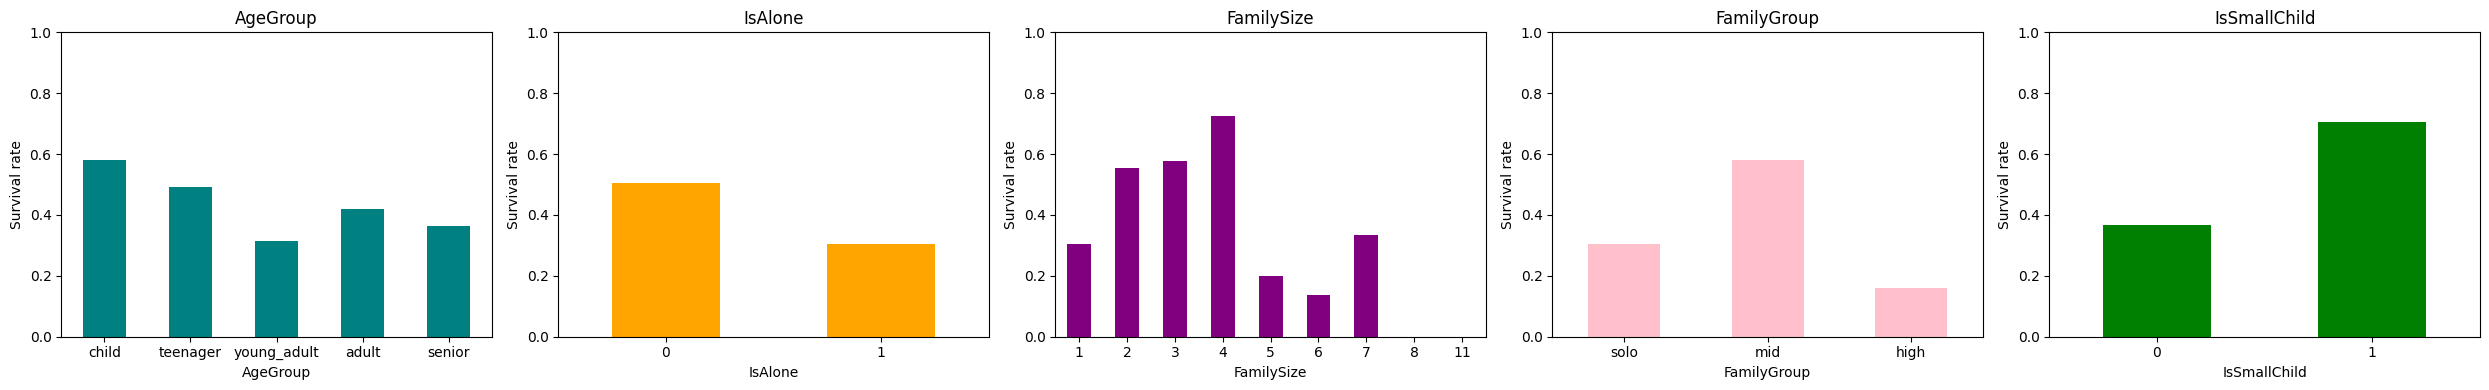

In [517]:
plot_survival_rates(
    df,
    ["AgeGroup", "IsAlone", "FamilySize", "FamilyGroup", "IsSmallChild"],
    orders={
        "AgeGroup": ["child", "teenager", "young_adult", "adult", "senior"],
        "IsAlone": df["IsAlone"].unique().sort(),
        "FamilySize": df["FamilySize"].unique().sort(),
        "FamilyGroup": ["solo", "mid", "high"],
    },
    colors=["teal", "orange", "purple", "pink", "green"],
)

**Survival rate grouped bar**

In [518]:
def plot_survival_rate_grouped_bar(
    df,
    x_col,
    hue_col,
    target_col="Survived",
    agg="mean",
    figsize=(9, 4),
    kind="bar",
    ylim=(0, 1),
    legend_title=None,
    legend_bbox=(1.05, 1),
    title=None,
    ylabel="Survival rate",
):
    pivot = df.groupby([x_col, hue_col])[target_col].agg(agg).unstack()

    ax = pivot.plot(kind=kind, figsize=figsize)

    ax.set_ylabel(ylabel)
    ax.set_ylim(*ylim)

    if title is None:
        title = f"{target_col} ({agg}) by {x_col} and {hue_col}"
    ax.set_title(title)

    if legend_title is None:
        legend_title = hue_col
    ax.legend(title=legend_title, bbox_to_anchor=legend_bbox)

    plt.tight_layout()
    plt.show()

    return pivot

`FamilyGroup` and `AgeGroup`

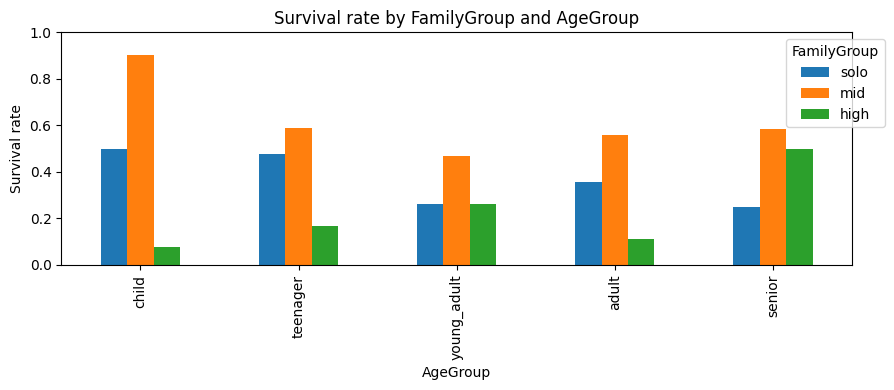

In [519]:
surv_2 = plot_survival_rate_grouped_bar(
    df,
    x_col="AgeGroup",
    hue_col="FamilyGroup",
    title="Survival rate by FamilyGroup and AgeGroup",
)

`FamilyGroup` and `AgeGroup`

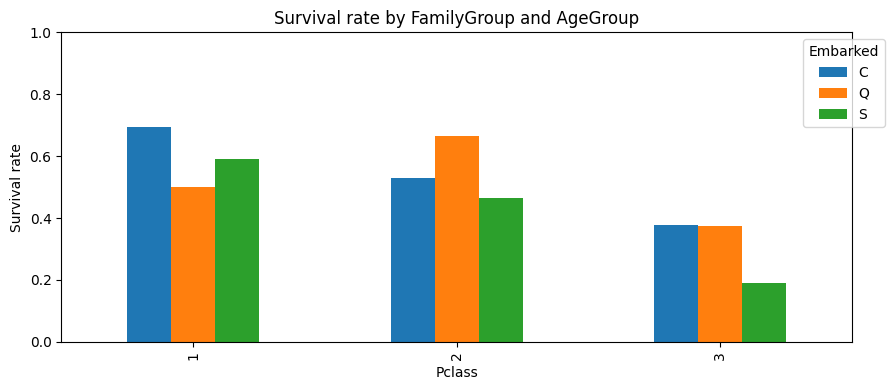

In [520]:
surv_2 = plot_survival_rate_grouped_bar(
    df,
    x_col="Pclass",
    hue_col="Embarked",
    title="Survival rate by FamilyGroup and AgeGroup",
)

In [521]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,IsSmallChild,AgeGroup,FamilySize,IsAlone,FamilyGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,young_adult,2,0,mid
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,0,adult,2,0,mid
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,young_adult,1,1,solo
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,0,adult,2,0,mid
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,adult,1,1,solo


`Fare`

In [522]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [523]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Compress the ticket price so extreme values dont dominate the model
df["Fare_log"] = np.log1p(df["Fare"])

# Scale the logged values
scaler = StandardScaler()
df["Fare_log_scaled"] = scaler.fit_transform(df[["Fare_log"]])

df[["Fare", "Fare_log", "Fare_log_scaled"]].head()

,Fare,Fare_log,Fare_log_scaled
0,7.2500,2.110213,-0.879741
1,71.2833,4.280593,1.361220
2,7.9250,2.188856,-0.798540
3,53.1000,3.990834,1.062038
4,8.0500,2.202765,-0.784179


In [524]:
df["Fare_log_scaled"].describe()

count    8.910000e+02
mean    -1.938841e-16
std      1.000562e+00
min     -3.058578e+00
25%     -8.002318e-01
50%     -2.316613e-01
75%      5.198636e-01
max      3.385294e+00
Name: Fare_log_scaled, dtype: float64

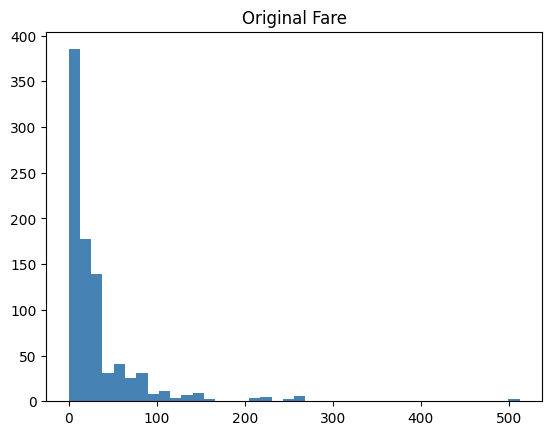

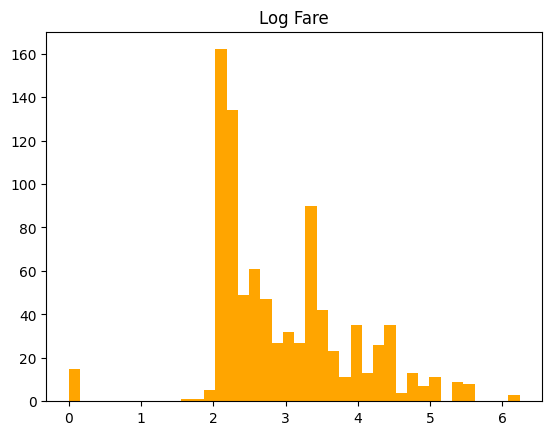

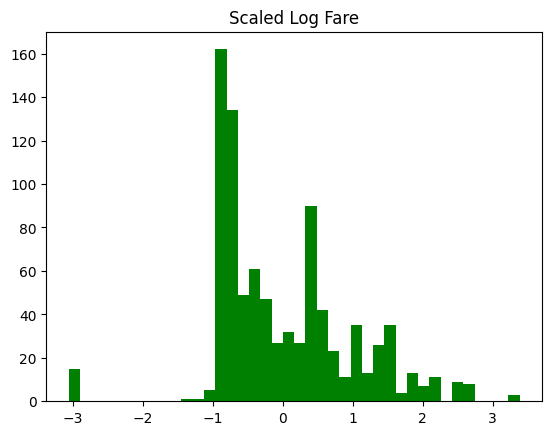

In [525]:
plt.figure()
plt.hist(df["Fare"], bins=40, color="steelblue")
plt.title("Original Fare")
plt.show()

plt.figure()
plt.hist(df["Fare_log"], bins=40, color="orange")
plt.title("Log Fare")
plt.show()

plt.figure()
plt.hist(df["Fare_log_scaled"], bins=40, color="green")
plt.title("Scaled Log Fare")
plt.show()

**`Title`**

## new_df

**drop columns**

In [526]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'IsSmallChild', 'AgeGroup', 'FamilySize',
       'IsAlone', 'FamilyGroup', 'Fare_log', 'Fare_log_scaled'],
      dtype='str')

In [527]:
cols_to_use = [
    "PassengerId",
    "Survived",
    "Pclass",
    "Sex",
    "Embarked",
    "IsSmallChild",
    "AgeGroup",
    "IsAlone",
    "FamilyGroup",
    "Fare_log_scaled",
]
new_df = df[cols_to_use].copy()
new_df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,IsSmallChild,AgeGroup,IsAlone,FamilyGroup,Fare_log_scaled
0,1,0,3,male,S,0,young_adult,0,mid,-0.879741
1,2,1,1,female,C,0,adult,0,mid,1.361220
2,3,1,3,female,S,0,young_adult,1,solo,-0.798540
3,4,1,1,female,S,0,adult,0,mid,1.062038
4,5,0,3,male,S,0,adult,1,solo,-0.784179


**`Sex`: Binary encoding**

In [528]:
print(f"Sex before: {df['Sex'].unique().tolist()}")
new_df["Sex"] = new_df["Sex"].map({"male": 0, "female": 1})
print(f"Sex after:  {new_df['Sex'].unique().tolist()}")

Sex before: ['male', 'female']
Sex after:  [0, 1]


**`Embarked`: OneHotEncoding**

In [529]:
embarked_map = {"S": "Southampton", "C": "Cherbourg", "Q": "Queenstown"}

new_df["Embarked"] = new_df["Embarked"].map(embarked_map)
new_df = pd.get_dummies(new_df, columns=["Embarked"], prefix="", prefix_sep="", dtype=int, drop_first=True)

new_df.head()

,PassengerId,Survived,Pclass,Sex,IsSmallChild,AgeGroup,IsAlone,FamilyGroup,Fare_log_scaled,Queenstown,Southampton
0,1,0,3,0,0,young_adult,0,mid,-0.879741,0,1
1,2,1,1,1,0,adult,0,mid,1.361220,0,0
2,3,1,3,1,0,young_adult,1,solo,-0.798540,0,1
3,4,1,1,1,0,adult,0,mid,1.062038,0,1
4,5,0,3,0,0,adult,1,solo,-0.784179,0,1


**`AgeGroup`: OrdinalEncoding**

In [530]:
print(f"AgeGroup before: {df['AgeGroup'].unique().tolist()}")
age_map = {"child": 0, "teenager": 1, "young_adult": 2, "adult": 3, "senior": 4}
new_df["AgeGroup"] = new_df["AgeGroup"].map(age_map)
print(f"AgeGroup after:  {new_df['AgeGroup'].unique().tolist()}")

AgeGroup before: ['young_adult', 'adult', 'senior', 'child', 'teenager']
AgeGroup after:  [2, 3, 4, 0, 1]


**`FamilyGroup`: OrdinalEncoding**

In [531]:
print(f"FamilyGroup before: {df['FamilyGroup'].unique().tolist()}")
family_map = {"solo": 0, "mid": 1, "high": 2}
new_df["FamilyGroup"] = new_df["FamilyGroup"].map(family_map)
print(f"FamilyGroup after:  {new_df['FamilyGroup'].unique().tolist()}")

FamilyGroup before: ['mid', 'solo', 'high']
FamilyGroup after:  [1, 0, 2]


**Sanity check**

In [532]:
new_df.dtypes

PassengerId           int64
Survived              int64
Pclass                int64
Sex                   int64
IsSmallChild          int64
AgeGroup           category
IsAlone               int64
FamilyGroup        category
Fare_log_scaled     float64
Queenstown            int64
Southampton           int64
dtype: object

In [533]:
new_df["AgeGroup"] = new_df["AgeGroup"].astype(int)
new_df["FamilyGroup"] = new_df["FamilyGroup"].astype(int)
new_df.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Sex                  int64
IsSmallChild         int64
AgeGroup             int64
IsAlone              int64
FamilyGroup          int64
Fare_log_scaled    float64
Queenstown           int64
Southampton          int64
dtype: object

In [534]:
print(new_df.isna().sum())
print(new_df.duplicated().sum())

PassengerId        0
Survived           0
Pclass             0
Sex                0
IsSmallChild       0
AgeGroup           0
IsAlone            0
FamilyGroup        0
Fare_log_scaled    0
Queenstown         0
Southampton        0
dtype: int64
0


**Correlations**

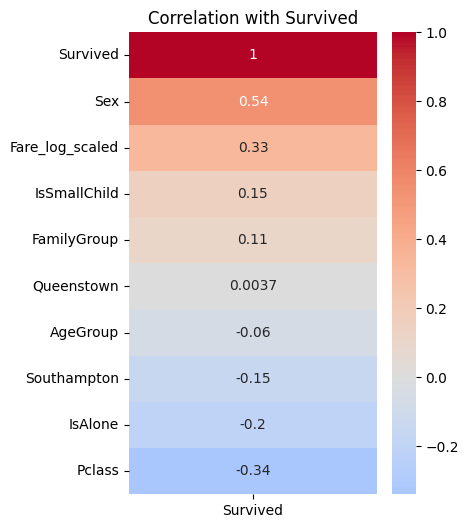

In [539]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 6))

corr_cols = [col for col in new_df.columns if col != "PassengerId"]

corr = (
    new_df[corr_cols]
    .corr(numeric_only=True)[["Survived"]]
    .sort_values(by="Survived", ascending=False)
)

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)

plt.title("Correlation with Survived")
plt.show()

## Models

**`X, y` split**

In [540]:
from sklearn.model_selection import train_test_split

X = new_df.drop(columns=["PassengerId", "AgeGroup", "Survived", "IsAlone"])
y = new_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}, y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (712, 7), X_test.shape: (179, 7), y_train.shape: (712,), y_test.shape: (179,)


**Logistic Regression**

In [541]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [542]:
from sklearn.metrics import accuracy_score, classification_report

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.776536312849162
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       105
           1       0.73      0.73      0.73        74

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

